# Generate Monthly Data

In this notebook, I will create a time-series monthly summary that tracks the transactional behaviors of customers during promotional and non-promotional situations.

The primary task will be to identify individuals who are likely to spend more money when receiving offers as compared to not receiving offers. Hence, we need a dataset that reflects how users respond in both promotional and non-promotional situations.

We are also interested if changes in customers' behaviors could happen over time.

Thus, we will aggregate customers' response on a monthly basis. Since we are not given actual dates, I will estimate a month to be 30 days and treat day 0 as the start of month 0.

Throughout the notebook, I will be using 'offer id 10' to represent non-offer situation for simplicity.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

warnings.filterwarnings(action='once')

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
#profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile = pd.read_csv('new_profile.csv')
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,gender,income,member_year,member_month,member_day,id
0,53.0,F,54000.0,2018,3,14,580a6914426040de911bbc5fc154f1b7
1,60.0,M,105000.0,2015,12,3,8c8c323df8e2415fbda5b2bbf253ca7b
2,34.0,M,36000.0,2018,3,31,64ebaad21838474d9ee5cab5e5f33cca
3,79.0,F,91000.0,2017,5,15,6ba699c43fd64dc598ceec20b4575ea1
4,56.0,F,59000.0,2017,11,13,f4a11bc75a014ad9996a79170fb59ec9


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Plot the distributions of demographics information

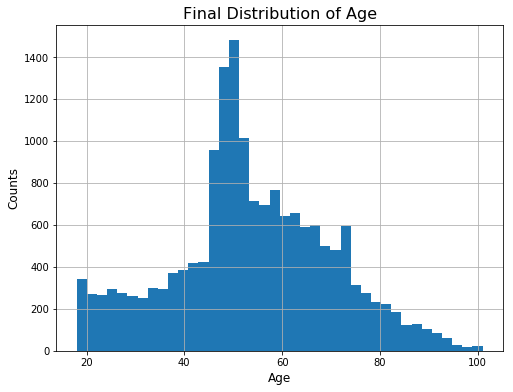

In [6]:
fig, ax = plt.subplots(figsize=(8,6));
profile.age.hist(bins=40, ax=ax)
ax.set_title("Final Distribution of Age", fontsize=16)
ax.set_xlabel("Age", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

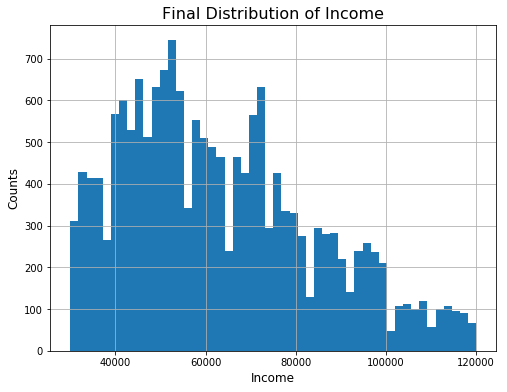

In [7]:
fig, ax = plt.subplots(figsize=(8,6));
profile.income.hist(bins=50, ax=ax)
ax.set_title("Final Distribution of Income", fontsize=16)
ax.set_xlabel("Income", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

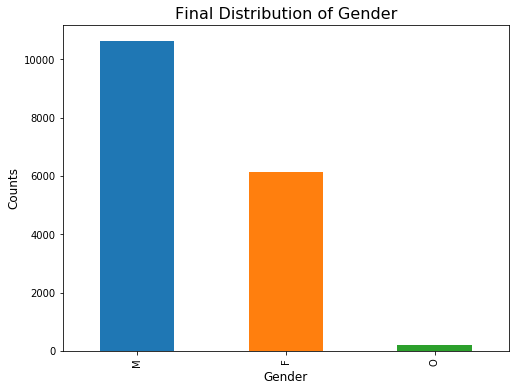

In [8]:
fig, ax = plt.subplots(figsize=(8,6));
profile.gender.value_counts().plot(kind='bar', ax=ax)
ax.set_title("Final Distribution of Gender", fontsize=16)
ax.set_xlabel("Gender", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

## Pre-process Data

In [9]:
def encode_person_id(profile_df, transcript_df):
    '''
    DESCRIPTION:
    Label encode hash values of id column for profile dataframe and person column for 
    transcript dataframe. Generates per_id variable.
    
    INPUTS:
    profile_df - the profile dataframe
    transcript_df - the transcript dataframe
    
    OUTPUTS:
    profile_df - The profile dataframe with the newly encoded per_id
    transcript_df - The transcript dataframe with the newly encoded per_id
    person_encoder - The label encoder object used to encode the hash values.
                     Can be used to retrieve original encodings
    '''
    person_encoder = LabelEncoder()
    profile_df['per_id'] = person_encoder.fit_transform(profile_df['id'])
    transcript_df['per_id'] = person_encoder.transform(transcript_df['person'])
    
    profile_df.drop(['id'], axis=1, inplace=True)
    transcript_df.drop(['person'], axis=1, inplace=True)
    
    return profile_df, transcript_df, person_encoder

profile, transcript, person_enocoder = encode_person_id(profile, transcript)
profile.head()

,age,gender,income,member_year,member_month,member_day,per_id
0,53.0,F,54000.0,2018,3,14,5853
1,60.0,M,105000.0,2015,12,3,9376
2,34.0,M,36000.0,2018,3,31,6687
3,79.0,F,91000.0,2017,5,15,7147
4,56.0,F,59000.0,2017,11,13,16253


In [10]:
# determine whether row deals with offer or transcation
transcript['value_type'] = transcript['value'].apply(lambda x : list(x.keys())[0])

# extract offer id if its an id, or transcation amount if it is a transcation
transcript['value_id_amt'] = transcript['value'].apply(lambda x : list(x.values())[0])

In [11]:
# ensure data types are consistent
def convert_data_type(df, int_var_list=None, float_var_list=None, str_var_list=None):
    '''
    DESCRIPTION:
    Ensure data types are consistent. Convert values in dataframe 
    into desired data types.
    
    INPUTS:
    df - The dataframe that we want to work with
    int_var_list - The list of variable to be converted to integers
    float_var_list - The list of variables to be converted to floats
    str_var_list - The list of variables to be converted to strings
    
    OUTPUTS:
    df - The dataframe that with the variables converted to the desired types
    '''
    if int_var_list != None:
        for int_var in int_var_list:
            df[int_var] = df[int_var].apply(lambda x: int(x))
        
    if float_var_list != None:
        for float_var in float_var_list:
            df[float_var] = df[float_var].apply(lambda x: float(x))
        
    if str_var_list != None:
        for str_var in str_var_list:
            df[str_var] = df[str_var].apply(lambda x: str(x))
        
    return df

In [12]:
# ensure age, per_id is int
# ensure gender is string
# ensure income is float

int_var_list = ['age', 'per_id']
float_var_list = ['income']
str_var_list = ['gender']

profile = convert_data_type(profile, int_var_list, float_var_list, str_var_list)

int_var_list = ['time', 'per_id']
str_var_list = ['event', 'value_type']

transcript = convert_data_type(transcript, int_var_list=int_var_list, str_var_list=str_var_list)

## Identify offers that were successfully completed or tried

In this section, I will re-create the probable outcomes of all the offers that were sent, and identify offers that were successful or tried.

A successful offer is one that has to be received, viewed and completed before the offer expired. This means that the customer was aware of a promotion and was making transactions as a result.

If the customer completed the offer before viewing it, the offer would not be classified as successful, since the customer as not influenced by the offer when making transactions. 

In the event that a customer made some transactions before viewing the offer, but did not spend enough to complete the offer. If he/she viewed the offer while it was still valid, and spent more money to complete it before it expired, the offer would be classified as successful as well.

Hence, the flow of events for a successful offer is:

time when offer received ≤ optional: time of transactions ≤ time when offer viewed ≤time of transactions ≤ time when offer completed ≤ time when offer expired

A tried offer is one that a customer viewed, spend some money before the offer expired but did not complete it. Hence the customer did not spend sufficient money to complete the offer's requirement.

Since informational offer do not have an offer completion event, they will be treated as a tried offer if the customer viewed the offer and spend some money during its validity.

The flow of events for a tried offer is:

time when offer received ≤ optional: time of transactions ≤ time when offer viewed ≤ time of transactions ≤ time when offer expired ≤ optional: time when offer completed

It is important to find these successful and tried offers because these are the offers that customers responded to and spent money on. These offers will capture the customers' promotional transaction behaviors.

In [13]:
# get transcript for offers only
transcript_offer = transcript[(transcript['value_type']=='offer id') | (transcript['value_type']=='offer_id')]
transcript_offer.drop(['value'], axis=1, inplace=True)
transcript_offer.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,time,per_id,value_type,value_id_amt
0,offer received,0,7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,0,10735,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,0,15043,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,0,9524,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,0,6939,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [14]:
# get transcript for transactions only
transcript_trans = transcript[transcript['value_type']=='amount']
transcript_trans.drop(['event', 'value', 'value_type'], axis=1, inplace=True)
transcript_trans.rename(index=str, columns={"time":"time_spent", "value_id_amt":"amt_spent"}, inplace=True)
transcript_trans.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,time_spent,per_id,amt_spent
12654,0,169,0.83
12657,0,10701,34.56
12659,0,5627,13.23
12670,0,11984,19.51
12671,0,16908,18.97


In [15]:
def encode_offer_id(portfolio_df, transcript_offer_df):
    '''
    DESCRIPTION:
    Encode hash values of id column for portfolio dataframe and value_id_amt column for 
    transcript_offer dataframe. Generates offer_id.
    
    INPUTS:
    profile_df - the profile dataframe
    transcript_df - the transcript dataframe
    
    OUTPUTS:
    profile_df - The profile dataframe with the newly encoded offer_id
    transcript_df - The transcript dataframe with the newly encoded offer_id
    offer_encoder - The label encoder object used to encode the hash values.
                     Can be used to retrieve original encodings
    '''
    offer_encoder = LabelEncoder()
    portfolio_df['offer_id'] = offer_encoder.fit_transform(portfolio_df['id'])
    transcript_offer_df['offer_id'] = offer_encoder.transform(transcript_offer_df['value_id_amt'])
    
    portfolio_df.drop(['id'], axis=1, inplace=True)
    transcript_offer_df.drop(['value_type', 'value_id_amt'], axis=1, inplace=True)
    
    return portfolio_df, transcript_offer_df, offer_encoder

portfolio, transcript_offer, offer_encoder = encode_offer_id(portfolio, transcript_offer)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
def encode_channel(portfolio_df):
    '''
    DESCRIPTION:
    Extract and perform one-hot encodings for the available channels in portfolio
    
    INPUTS:
    portfolio_df - The portfolio dataframe
    
    OUTPUTS:
    portfolio_df - The portfolio dataframe with the one-hot encoded channels
    '''
    # find all available channels
    available_channels = []
    for channel_list in portfolio_df['channels']:
        for channel in channel_list:
            if channel not in available_channels:
                available_channels.append(channel)
    
    # one-hot encode channel
    for channel in available_channels:
        portfolio_df[channel] = portfolio_df['channels'].apply(lambda x: 1 if channel in x else 0)
    
    # drop channels column
    portfolio_df.drop(['channels'], axis=1, inplace=True)
    
    return portfolio_df

portfolio = encode_channel(portfolio)
portfolio

,difficulty,duration,offer_type,reward,offer_id,email,mobile,social,web
0,10,7,bogo,10,7,1,1,1,0
1,10,5,bogo,10,4,1,1,1,1
2,0,4,informational,0,3,1,1,0,1
3,5,7,bogo,5,6,1,1,0,1
4,20,10,discount,5,0,1,0,0,1
5,7,7,discount,3,1,1,1,1,1
6,10,10,discount,2,9,1,1,1,1
7,0,3,informational,0,5,1,1,1,0
8,5,5,bogo,5,8,1,1,1,1
9,10,7,discount,2,2,1,1,0,1


In [17]:
transcript[transcript['per_id']==7996].head(7)

,event,time,value,per_id,value_type,value_id_amt
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
47582,transaction,132,{'amount': 19.89},7996,amount,19.89
47583,offer completed,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,7996,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
49502,transaction,144,{'amount': 17.78},7996,amount,17.78
53176,offer received,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},7996,offer id,5a8bc65990b245e5a138643cd4eb9837
85291,offer viewed,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},7996,offer id,5a8bc65990b245e5a138643cd4eb9837


In [18]:
# merge transcript_offer with portfolio
transcript_offer = pd.merge(transcript_offer, portfolio, how='left', on='offer_id')

I will now split transcript_offer into 3 different dataframes: One tracking when offers are received, the other tracking when offers are viewed and the last tracking when offers are completed. Doing so will allow us to merge all 3 together to obtain a summary of the offers. Some of the offers obtained through the merging process will be nonsensical offers. We will need to eliminate such offers.

In [19]:
# generate dataframe tracking offers received
transcript_offer_received = transcript_offer[transcript_offer['event']=='offer received']
transcript_offer_received.rename(index=str, columns={"time":"time_received"}, inplace=True)
transcript_offer_received.drop(['event'], axis=1, inplace=True)
transcript_offer_received.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0,7996,6,5,7,bogo,5,1,1,0,1
1,0,10735,0,20,10,discount,5,1,0,0,1
2,0,15043,2,10,7,discount,2,1,1,0,1
3,0,9524,9,10,10,discount,2,1,1,1,1
4,0,6939,4,10,5,bogo,10,1,1,1,1


In [20]:
# generate dataframe tracking offers viewed
transcript_offer_viewed = transcript_offer[transcript_offer['event']=='offer viewed']
transcript_offer_viewed.rename(index=str, columns={"time":"time_viewed"}, inplace=True)
cols_to_drop = ['event', 'difficulty', 'duration', 'offer_type', 'reward',\
                'email', 'mobile', 'social', 'web']
transcript_offer_viewed.drop(cols_to_drop, axis=1, inplace=True)
transcript_offer_viewed.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,time_viewed,per_id,offer_id
12650,0,3728,8
12651,0,13994,5
12652,0,1051,4
12653,0,169,7
12654,0,12743,5


In [21]:
# generate dataframe tracking offers completed
transcript_offer_completed = transcript_offer[transcript_offer['event']=='offer completed']
transcript_offer_completed.rename(index=str, columns={"time":"time_completed"}, inplace=True)
transcript_offer_completed.drop(cols_to_drop, axis=1, inplace=True)
transcript_offer_completed.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,time_completed,per_id,offer_id
12656,0,10701,2
12667,0,16908,9
12673,0,6534,6
12683,0,6862,7
12687,0,9576,4


In [22]:
all_offers = pd.merge(transcript_offer_received, transcript_offer_viewed, on=['per_id', 'offer_id'], how='left')
all_offers = pd.merge(all_offers, transcript_offer_completed, on=['per_id', 'offer_id'], how='left')
all_offers.head()

,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web,time_viewed,time_completed
0,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0
1,0,10735,0,20,10,discount,5,1,0,0,1,6.0,NaN
2,0,10735,0,20,10,discount,5,1,0,0,1,624.0,NaN
3,0,15043,2,10,7,discount,2,1,1,0,1,18.0,NaN
4,0,9524,9,10,10,discount,2,1,1,1,1,12.0,NaN


At this stage, alot of offers generated through the merging process are false offers. We will try to eliminate these offers.

We will now keep keep only offers that meet the following conditions:

1. (time offer viewed > time offer received) and (time offer completed > time offer viewed)
2. (time offer viewed > time offer received) and (time completed is null)
3. both time offer viewed and time offer completed are null

Offers that do not meet these conditions are false offers and will be discarded.

In [23]:
# add time of offer expiry column
all_offers['time_expiry'] = all_offers['time_received'] + all_offers['duration']

# add time_viewed > time_received and time_completed is null
# if time_viewed is null and time_completed is null
all_offers = all_offers[((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        (all_offers['time_completed'] >= all_offers['time_viewed']))
                        |
                        ((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        all_offers['time_completed'].isnull())
                        |
                        (all_offers['time_viewed'].isnull() &\
                         all_offers['time_completed'].isnull())
                       ]


all_offers.head(10)

,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web,time_viewed,time_completed,time_expiry
0,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7
1,0,10735,0,20,10,discount,5,1,0,0,1,6.0,NaN,10
2,0,10735,0,20,10,discount,5,1,0,0,1,624.0,NaN,10
3,0,15043,2,10,7,discount,2,1,1,0,1,18.0,NaN,7
4,0,9524,9,10,10,discount,2,1,1,1,1,12.0,NaN,10
5,0,9524,9,10,10,discount,2,1,1,1,1,522.0,NaN,10
6,0,6939,4,10,5,bogo,10,1,1,1,1,84.0,NaN,5
7,0,3728,8,5,5,bogo,5,1,1,1,1,0.0,60.0,5
8,0,3728,8,5,5,bogo,5,1,1,1,1,0.0,600.0,5
10,0,3728,8,5,5,bogo,5,1,1,1,1,504.0,600.0,5


Now, we will attempt to classify the offers to their probable outcomes.

Offers that are probably successful will be offers that are viewed sometime after they are received but before the offer is completed. This means that the customer is aware of an offer and is making transactions as a result of the offer. In addition, the offer must be completed before it expires. Likewise the time of vewing must also come before the time of completion.

Offers that are probably tried are offers that are either
1. received, viewed but completed after time of expiration
or 
2. received, viewed before the offer expires but the offer is not completed.

Offers that have failed or are false offers will be offers that do not belong to any of the above two classes.

Right now, the classifications are just probable. We will use the transactions data to re-affirm these classifications. We will check if there are any transactions that occur during these offers.

In [24]:
# tracks which offers are successful
# these are offers which are received, viewed and completed within the offers' durations
successful_offer = []

# tracks which offers are tried
# these are offers which are received, viewed but not completed within the offers' durations
tried_offer = []

# tracks all offers that failed or are invalid
# these are offers that are never viewed
failed_offer = []

# tracks time between offer viewed and expiry of offer (time_received + duration)
time_offer_in_effect = []

for row_num, col in all_offers.iterrows():
    if ((col['time_viewed'] <= col['time_expiry']) &
    (col['time_completed'] <= col['time_expiry']) &
    (col['time_viewed'] >= col['time_received']) &
    (col['time_completed'] >= col['time_viewed'])):
        successful_offer.append(1)
        tried_offer.append(0)
        failed_offer.append(0)
        time_offer_in_effect.append(col['time_completed'] - col['time_viewed'])
    elif (((col['time_viewed'] <= col['time_expiry']) &
    (col['time_completed'] > col['time_expiry']) &
    (col['time_viewed'] >= col['time_received']) &
    (col['time_completed'] >= col['time_viewed']))
    |\
    ((col['time_viewed'] <= col['time_expiry']) &
    (math.isnan(col['time_completed'])) &
    (col['time_viewed'] >= col['time_received']))):
        successful_offer.append(0)
        tried_offer.append(1)
        failed_offer.append(0)
        time_offer_in_effect.append(col['time_expiry'] - col['time_viewed'])
    else:
        successful_offer.append(0)
        tried_offer.append(0)
        failed_offer.append(1)
        time_offer_in_effect.append(0)

all_offers['successful_offer'] = successful_offer
all_offers['tried_offer'] = tried_offer
all_offers['failed_offer'] = failed_offer
all_offers['time_offer_in_effect'] = time_offer_in_effect

We will drop all duplicated entries including those with duplicated time of receival, person id and offer id. No indivduals received the same offer twice during the same day.

These duplicated entries are eraneous entries generated from the merging process.

In [25]:
# drop all rows with duplicated per_id, offer_id and time_received
# very likely they are double counting
all_offers.drop_duplicates(subset=['time_received', 'per_id', 'offer_id'], keep='first', inplace=True)

print(all_offers.shape)
print(transcript_offer_received.shape)

(65109, 18)
(76277, 11)


In [26]:
# get subset of offers that are successfully completed or tried
succ_tried_offers = all_offers[(all_offers['successful_offer']==1) | (all_offers['tried_offer']==1)]
succ_tried_offers.head()

,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,time_offer_in_effect
0,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7,0,1,0,1.0
1,0,10735,0,20,10,discount,5,1,0,0,1,6.0,NaN,10,0,1,0,4.0
7,0,3728,8,5,5,bogo,5,1,1,1,1,0.0,60.0,5,0,1,0,5.0
39,0,1051,4,10,5,bogo,10,1,1,1,1,0.0,6.0,5,0,1,0,5.0
44,0,169,7,10,7,bogo,10,1,1,1,0,0.0,NaN,7,0,1,0,7.0


We will now do a cross-product between all successful/tried offers and all transactions. We can then check if the spending occurred during the offer by checking if the time of spending.

If an offer is probably successful, then the spending should occur after the offer is received and before the offer is completed.

If an offer is probably tried, then the spending should occur after the offer is received but before the offer has expired.

If transactions occurred while the offer is still valid, then the offer is considered truly successful or tried.

In [27]:
succ_tried_offers = pd.merge(succ_tried_offers, transcript_trans, on='per_id', how='left')
succ_tried_offers.head()

,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,time_offer_in_effect,time_spent,amt_spent
0,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7,0,1,0,1.0,132.0,19.89
1,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7,0,1,0,1.0,144.0,17.78
2,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7,0,1,0,1.0,222.0,19.67
3,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7,0,1,0,1.0,240.0,29.72
4,0,7996,6,5,7,bogo,5,1,1,0,1,6.0,132.0,7,0,1,0,1.0,378.0,23.93


In [28]:
# tracks if transcaction was part of offer or not
spent_during_offer_bool = []

for row_num, col in succ_tried_offers.iterrows():
    if col['successful_offer'] == 1:
        # orginally >= col['time_viewed']
        if (col['time_spent'] >= col['time_received']) and (col['time_spent'] <= col['time_completed']):
            spent_during_offer_bool.append(1)
        else:
            spent_during_offer_bool.append(0)
    else: #col['tried_offer'] == 1:
        # orginally >= col['time_viewed']
        if (col['time_spent'] >= col['time_received']) and (col['time_spent'] <= col['time_expiry']):
            spent_during_offer_bool.append(1)
        else:
            spent_during_offer_bool.append(0)
        
succ_tried_offers['spent_during_offer'] = spent_during_offer_bool

# offers that have transactions occuring during their validity period are very likely to be actual offers
succ_tried_offers = succ_tried_offers[succ_tried_offers['spent_during_offer']==1]

succ_tried_offers.head()

,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,...,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,time_offer_in_effect,time_spent,amt_spent,spent_during_offer
27,0,169,7,10,7,bogo,10,1,1,1,...,0.0,NaN,7,0,1,0,7.0,0.0,0.83,1
28,0,169,7,10,7,bogo,10,1,1,1,...,0.0,NaN,7,0,1,0,7.0,6.0,1.44,1
55,0,6862,7,10,7,bogo,10,1,1,1,...,0.0,0.0,7,1,0,0,0.0,0.0,18.01,1
63,0,10701,2,10,7,discount,2,1,1,0,...,0.0,0.0,7,1,0,0,0.0,0.0,34.56,1
182,0,15772,2,10,7,discount,2,1,1,0,...,0.0,NaN,7,0,1,0,7.0,0.0,1.16,1


In [29]:
succ_tried_offers.isnull().mean()

time_received           0.000000
per_id                  0.000000
offer_id                0.000000
difficulty              0.000000
duration                0.000000
offer_type              0.000000
reward                  0.000000
email                   0.000000
mobile                  0.000000
social                  0.000000
web                     0.000000
time_viewed             0.000000
time_completed          0.280556
time_expiry             0.000000
successful_offer        0.000000
tried_offer             0.000000
failed_offer            0.000000
time_offer_in_effect    0.000000
time_spent              0.000000
amt_spent               0.000000
spent_during_offer      0.000000
dtype: float64

## Find all failed offers

We will now find out which offers had failed, meaning customers did not spend any money on these offers. We have the list of all offers that were sent by the company in transcript_offer_received. We also have the list of offers that customers did spent money for in succ_tried_offers. Hence the difference of the two can tell us which offers actually failed.

In [30]:
# find all offers that were sent
all_offers = transcript_offer_received[['time_received', 'per_id', 'offer_id']]
all_offers.head()

,time_received,per_id,offer_id
0,0,7996,6
1,0,10735,0
2,0,15043,2
3,0,9524,9
4,0,6939,4


In [31]:
succ_tried_offers_summary = succ_tried_offers.groupby(['time_received',\
                                                       'per_id',\
                                                       'offer_id']).agg({'successful_offer':'min',\
                                                                         'tried_offer':'min',\
                                                                         'failed_offer':'min'}).reset_index()
succ_tried_offers_summary.head()

,time_received,per_id,offer_id,successful_offer,tried_offer,failed_offer
0,0,54,7,1,0,0
1,0,60,1,0,1,0
2,0,121,4,1,0,0
3,0,128,9,1,0,0
4,0,169,7,0,1,0


In [32]:
all_offers = pd.merge(all_offers, succ_tried_offers_summary, on=['time_received', 'per_id', 'offer_id'], how='left')
all_offers.head()

,time_received,per_id,offer_id,successful_offer,tried_offer,failed_offer
0,0,7996,6,NaN,NaN,NaN
1,0,10735,0,NaN,NaN,NaN
2,0,15043,2,NaN,NaN,NaN
3,0,9524,9,NaN,NaN,NaN
4,0,6939,4,NaN,NaN,NaN


In [33]:
# rows with NaN values in all 3 columns (successful_offer, tried_offer, failed_offer) are offers that failed
all_offers['successful_offer'].fillna(0, inplace=True)
all_offers['tried_offer'].fillna(0, inplace=True)
all_offers['failed_offer'].fillna(1, inplace=True)

all_offers.head()

,time_received,per_id,offer_id,successful_offer,tried_offer,failed_offer
0,0,7996,6,0.0,0.0,1.0
1,0,10735,0,0.0,0.0,1.0
2,0,15043,2,0.0,0.0,1.0
3,0,9524,9,0.0,0.0,1.0
4,0,6939,4,0.0,0.0,1.0


In [34]:
failed_offers = all_offers[all_offers['failed_offer']==1]
failed_offers.head()

,time_received,per_id,offer_id,successful_offer,tried_offer,failed_offer
0,0,7996,6,0.0,0.0,1.0
1,0,10735,0,0.0,0.0,1.0
2,0,15043,2,0.0,0.0,1.0
3,0,9524,9,0.0,0.0,1.0
4,0,6939,4,0.0,0.0,1.0


In [35]:
def assign_month_num(df, time_col, month_name_col='month_num'):
    '''
    DESCRIPTION:
    Convert the days into the appropriate months. Based on the assumption that
    a month contains 30 days.
    
    INPUTS:
    df - The original dataframe
    time_col - The variable tracking the day
    month_name_col - The name for the newly generated variable to track the month
    
    OUTPUTS:
    df - The dataframe with the appropriate months
    '''
    start_of_month = np.arange(0,721,30)
    end_of_month = np.arange(29,750,30)
    month_name_list = []
    
    for i in range(len(start_of_month)):
        month_name = str(start_of_month[i]) + "_" + str(end_of_month[i])
        month_name_list.append(month_name)
    
    df_month_num = []
    df_month_name = []
    for row, col in df.iterrows():
        month_num = int(col[time_col] // 30)
        month_name = month_name_list[month_num]
        df_month_num.append(month_num)
        df_month_name.append(month_name)
    
    df[month_name_col] = df_month_num
    df['month_name'] = df_month_name
    
    return df

In [36]:
failed_offers = assign_month_num(failed_offers, 'time_received')
failed_offers['monthly_amt_spent'] = 0
failed_offers['num_trans'] = 0
monthly_failed_offers = failed_offers[['month_num', 'per_id', 'offer_id', 'monthly_amt_spent', 'num_trans']]
monthly_failed_offers.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,month_num,per_id,offer_id,monthly_amt_spent,num_trans
0,0,7996,6,0,0
1,0,10735,0,0,0
2,0,15043,2,0,0
3,0,9524,9,0,0
4,0,6939,4,0,0


We now have the monthly summary of offers that failed. Customers did not attempt these offers at all.

## Monthly summary of all transactions that are carried out

We will now produce a monthly summary of customers' transaction behaviors. At the end of this section, we will know how much each customer spent and how many transactions he/she carried out for each offer type. This also includes offer id 10 which tracks non-offer transactions

In [37]:
# check if there are duplicted per_id, time_spent, amt_spent
succ_tried_offers[succ_tried_offers.duplicated(subset=['time_spent', 'per_id', 'amt_spent', 'offer_id'])]

,time_received,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,...,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,time_offer_in_effect,time_spent,amt_spent,spent_during_offer


In [38]:
offer_transactions = succ_tried_offers[['time_spent', 'per_id', 'amt_spent', 'spent_during_offer', 'offer_id']]

transactions_labeled = pd.merge(transcript_trans, offer_transactions, on=['time_spent', 'per_id', 'amt_spent'], how='left')

# these are non-offer transactions
transactions_labeled['spent_during_offer'].fillna(0, inplace=True)
transactions_labeled['offer_id'].fillna(10, inplace=True)

transactions_labeled.head()

,time_spent,per_id,amt_spent,spent_during_offer,offer_id
0,0,169,0.83,1.0,7.0
1,0,10701,34.56,1.0,2.0
2,0,5627,13.23,0.0,10.0
3,0,11984,19.51,0.0,10.0
4,0,16908,18.97,0.0,10.0


In [39]:
transactions_labeled = assign_month_num(transactions_labeled, 'time_spent')
transactions_labeled.head()

,time_spent,per_id,amt_spent,spent_during_offer,offer_id,month_num,month_name
0,0,169,0.83,1.0,7.0,0,0_29
1,0,10701,34.56,1.0,2.0,0,0_29
2,0,5627,13.23,0.0,10.0,0,0_29
3,0,11984,19.51,0.0,10.0,0,0_29
4,0,16908,18.97,0.0,10.0,0,0_29


In [40]:
transcript_offer = assign_month_num(transcript_offer, 'time')
transcript_offer.head()

,event,time,per_id,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web,month_num,month_name
0,offer received,0,7996,6,5,7,bogo,5,1,1,0,1,0,0_29
1,offer received,0,10735,0,20,10,discount,5,1,0,0,1,0,0_29
2,offer received,0,15043,2,10,7,discount,2,1,1,0,1,0,0_29
3,offer received,0,9524,9,10,10,discount,2,1,1,1,1,0,0_29
4,offer received,0,6939,4,10,5,bogo,10,1,1,1,1,0,0_29


In [41]:
monthly_transactions = transactions_labeled.groupby(['month_num',\
                                                     'per_id',\
                                                     'offer_id']).agg({'amt_spent':'sum',\
                                                                       'spent_during_offer':'count'
                                                                      }).reset_index()

monthly_transactions.rename(index=str, columns={"amt_spent":"monthly_amt_spent",\
                                                "spent_during_offer":"num_trans"
                                               }, inplace=True)
monthly_transactions.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans
0,0,7,10.0,25.62,1
1,0,13,10.0,27.26,1
2,0,18,10.0,46.00,3
3,0,22,10.0,6.03,1
4,0,32,10.0,19.84,1


## Find out which customers did not make any non-promotional transactions and the months these events occurred

We will now find out which months did individuals not spend any money during non-promotional situations.

We start off by producing the dataframe of all possible month, person and offer_id_10 instances. Offer id 10 is used to track non-promotional transactions. We will call this dataframe non_offer_trans.

Every month, we will only add individuals whom we have seen so far in the transcript. This ensures that we tracking individuals only after they became starbucks customers.

Next we will do a left merge of the labelled transactions to non_offer_trans. Any entry in non_offer_trans with NaN values after the merging means that during that month, the customer did not make any non-offer transactions

We will then isolate the portion of non_offer_trans with null values. With this, we will know which customers did not perform any non-promotional transactions and during which months did these events occur

In [47]:
transcript_month = assign_month_num(transcript, 'time')
transcript_month.head()

,event,time,value,per_id,value_type,value_id_amt,month_num,month_name
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0_29
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},10735,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0_29
2,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},15043,offer id,2906b810c7d4411798c6938adc9daaa5,0,0_29
3,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},9524,offer id,fafdcd668e3743c1bb461111dcafc2a4,0,0_29
4,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},6939,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0_29


In [48]:
# Each month, add only individuals who we have seen so far in the transcript
person_seen_so_far = np.array([])

time_periods = transactions_labeled.month_num.max()

month_col = np.array([])
per_id_col = np.array([])
offer_id_col = np.array([])

for month_num in range(time_periods):
    #trans_subset = transcript_offer[transcript_offer['month_num']==month_num]
    trans_subset = transcript_month[transcript_month['month_num']==month_num]
    person_seen = trans_subset.per_id.unique()
    person_seen = np.sort(person_seen)
    person_seen_so_far = np.append(person_seen_so_far, person_seen)
    person_seen_so_far = np.unique(person_seen_so_far)
    person_seen_so_far = np.sort(person_seen_so_far)
    
    per_id_col = np.append(per_id_col, person_seen_so_far)
    month_col = np.append(month_col, np.repeat(np.array(month_num), len(person_seen_so_far)))
    offer_id_col = np.append(offer_id_col, np.repeat(np.array(10), len(person_seen_so_far)))
    
non_offer_trans = pd.DataFrame({'month_num':month_col,'per_id':per_id_col,'offer_id':offer_id_col})

non_offer_trans.head()

,month_num,per_id,offer_id
0,0.0,2.0,10.0
1,0.0,3.0,10.0
2,0.0,5.0,10.0
3,0.0,6.0,10.0
4,0.0,7.0,10.0


In [49]:
# find the months when a person did not perform any transactions associated with no offers

non_offer_trans = pd.merge(non_offer_trans, monthly_transactions, on=['month_num', 'per_id', 'offer_id'], how='left')
non_offer_trans.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans
0,0.0,2.0,10.0,NaN,NaN
1,0.0,3.0,10.0,NaN,NaN
2,0.0,5.0,10.0,NaN,NaN
3,0.0,6.0,10.0,NaN,NaN
4,0.0,7.0,10.0,25.62,1.0


In [50]:
non_offer_trans['monthly_amt_spent'].fillna(0, inplace=True)
non_offer_trans['num_trans'].fillna(0, inplace=True)

non_offer_trans.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans
0,0.0,2.0,10.0,0.00,0.0
1,0.0,3.0,10.0,0.00,0.0
2,0.0,5.0,10.0,0.00,0.0
3,0.0,6.0,10.0,0.00,0.0
4,0.0,7.0,10.0,25.62,1.0


In [51]:
# during these months, individuals receive no offers and made no transactions
no_offer_no_trans = non_offer_trans[non_offer_trans['num_trans']==0]
no_offer_no_trans.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans
0,0.0,2.0,10.0,0.0,0.0
1,0.0,3.0,10.0,0.0,0.0
2,0.0,5.0,10.0,0.0,0.0
3,0.0,6.0,10.0,0.0,0.0
5,0.0,9.0,10.0,0.0,0.0


## Build data

We will now combine the monthly summary of transactions, the monthly summary of failed offers and the monthly summary of when no non-promotional spending occurred. The resulting dataframe tracks on a monthly basis:

1. which offer type a customer recieved and how much did he/she spend on them and how many transactions did he/she carried out for them
2. did customers make any non-promotional transactions. If so how much did he/she spent and how many transactions did he/she carried out.

In [52]:
monthly_data = pd.concat([monthly_transactions, monthly_failed_offers], axis=0)
monthly_data = pd.concat([monthly_data, no_offer_no_trans], axis=0)
monthly_data.sort_values(by=['month_num', 'per_id', 'offer_id'], inplace=True)
monthly_data.reset_index(drop=True, inplace=True)

monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans
0,0.0,2.0,3.0,0.0,0.0
1,0.0,2.0,10.0,0.0,0.0
2,0.0,3.0,9.0,0.0,0.0
3,0.0,3.0,10.0,0.0,0.0
4,0.0,5.0,5.0,0.0,0.0


In [53]:
monthly_data['amt_spent_per_trans'] = monthly_data['monthly_amt_spent'] / monthly_data['num_trans']

monthly_data['amt_spent_per_trans'].fillna(0, inplace=True)

monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans
0,0.0,2.0,3.0,0.0,0.0,0.0
1,0.0,2.0,10.0,0.0,0.0,0.0
2,0.0,3.0,9.0,0.0,0.0,0.0
3,0.0,3.0,10.0,0.0,0.0,0.0
4,0.0,5.0,5.0,0.0,0.0,0.0


In [54]:
monthly_data.offer_id.value_counts()

10.0    378396
6.0       7677
0.0       7669
7.0       7665
1.0       7653
2.0       7632
5.0       7618
3.0       7617
9.0       7599
4.0       7593
8.0       7571
Name: offer_id, dtype: int64

## Find out if an individual can receive the same offer twice in a month

This section will show that a customer is never under the effect of more than one instance of an offer type every month. We show this by demonstrating that no customers receive the same type of offer more than once in a month. If a customer received an offer that ends during the next month, he/she will not receive the same type of offer during the next month as well.

In [55]:
# find all offers that were sent
all_offers = transcript_offer_received[['time_received', 'per_id', 'offer_id', 'difficulty', 'duration']]
all_offers['time_end'] = all_offers['time_received'] + all_offers['duration']
all_offers = assign_month_num(all_offers, 'time_received', 'start_month_num')
all_offers_summary = all_offers.groupby(['start_month_num', 'per_id', 'offer_id']).agg({'difficulty':'count', 'time_end':'min'}).reset_index()
all_offers_summary.rename(index=str, columns={"difficulty":"num_offers"}, inplace=True)
all_offers_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,start_month_num,per_id,offer_id,num_offers,time_end
0,0,2,3,1,4
1,0,3,9,1,10
2,0,5,5,1,3
3,0,6,5,1,3
4,0,9,7,1,7


In [56]:
# no one received the same offer twice in a month
all_offers_summary[all_offers_summary['num_offers']>1]

,start_month_num,per_id,offer_id,num_offers,time_end


In [57]:
# show that for offers which ends in a different month than it started, they do not end in a month that a new offer is sent
all_offers_summary = assign_month_num(all_offers_summary, 'time_end', 'end_month_num')
all_offers_summary.head()

,start_month_num,per_id,offer_id,num_offers,time_end,end_month_num,month_name
0,0,2,3,1,4,0,0_29
1,0,3,9,1,10,0,0_29
2,0,5,5,1,3,0,0_29
3,0,6,5,1,3,0,0_29
4,0,9,7,1,7,0,0_29


In [58]:
# offers that end in a different month then they started
diff_months_df = all_offers_summary[all_offers_summary['start_month_num']!=all_offers_summary['end_month_num']].head()
diff_months_df.head()

,start_month_num,per_id,offer_id,num_offers,time_end,end_month_num,month_name
50808,16,0,9,1,514,17,510_539
50809,16,2,6,1,511,17,510_539
50811,16,4,6,1,511,17,510_539
50812,16,5,0,1,514,17,510_539
50815,16,9,6,1,511,17,510_539


In [59]:
all_offers_summary_check = pd.merge(all_offers_summary, diff_months_df, on=['per_id', 'offer_id'], how='left')
all_offers_summary_check.head()

,start_month_num_x,per_id,offer_id,num_offers_x,time_end_x,end_month_num_x,month_name_x,start_month_num_y,num_offers_y,time_end_y,end_month_num_y,month_name_y
0,0,2,3,1,4,0,0_29,NaN,NaN,NaN,NaN,NaN
1,0,3,9,1,10,0,0_29,NaN,NaN,NaN,NaN,NaN
2,0,5,5,1,3,0,0_29,NaN,NaN,NaN,NaN,NaN
3,0,6,5,1,3,0,0_29,NaN,NaN,NaN,NaN,NaN
4,0,9,7,1,7,0,0_29,NaN,NaN,NaN,NaN,NaN


In [60]:
# check for offers expiring in a different month, can any person receive the same type of offer again during the month
# eg check if any person receive offer type 0 at month 16 that expires at month 17, and receive another offer of type 0 at time 17
all_offers_summary_check[all_offers_summary_check['start_month_num_x'] == all_offers_summary_check['end_month_num_y']]

,start_month_num_x,per_id,offer_id,num_offers_x,time_end_x,end_month_num_x,month_name_x,start_month_num_y,num_offers_y,time_end_y,end_month_num_y,month_name_y


No individuals received the same offer more than once in a month. In addition, if an individual received an offer that ends during the next month, no one received a similar offer during the next month. Hence, a peson will only be exposed to an offer type once every month. 

## Compute Profits

We will compute the amount of profits generated by each instance in the monthly dataset.

Since customers were only exposed to a maximum of 1 occurrence of an offer type every month, this means that the cost in monthly_data is simply the reward of the promotion if it was completed.

We can calculate the amount of profits each individual generated for each offer type each month by following the 3 rules:
1. If the offer was successful, the profit would be the monthly revenue minus the cost of the offer. Note that informational offers have no cost. 
2. If the offer was not successful, the profit would be the revenue generated in that instance.
3. If the transactions were not made as part of an offer, the profit would be the revenue since there are no cost involved.

In [61]:
# customers are never exposed to more than one type of offer every month
# we will record monthly non-promotional transactions as having occurred under 1 'offer_id_10' per month
monthly_data['num_offers'] = 1
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers
0,0.0,2.0,3.0,0.0,0.0,0.0,1
1,0.0,2.0,10.0,0.0,0.0,0.0,1
2,0.0,3.0,9.0,0.0,0.0,0.0,1
3,0.0,3.0,10.0,0.0,0.0,0.0,1
4,0.0,5.0,5.0,0.0,0.0,0.0,1


In [62]:
offer_cost = portfolio[['offer_id', 'difficulty', 'reward']]
offer_cost.head()

,offer_id,difficulty,reward
0,7,10,10
1,4,10,10
2,3,0,0
3,6,5,5
4,0,20,5


In [63]:
monthly_data = pd.merge(monthly_data, offer_cost, on='offer_id', how='left')
# these are no offer. So fill NaN with 0 cost
monthly_data['reward'].fillna(0, inplace=True)
monthly_data['difficulty'].fillna(0, inplace=True)
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,difficulty,reward
0,0.0,2.0,3.0,0.0,0.0,0.0,1,0.0,0.0
1,0.0,2.0,10.0,0.0,0.0,0.0,1,0.0,0.0
2,0.0,3.0,9.0,0.0,0.0,0.0,1,10.0,2.0
3,0.0,3.0,10.0,0.0,0.0,0.0,1,0.0,0.0
4,0.0,5.0,5.0,0.0,0.0,0.0,1,0.0,0.0


In [64]:
monthly_data_cost = []

bogo_disc_offer_ids = [0,1,2,4,6,7,8,9]

for row, col in monthly_data.iterrows():
    # if individual successfully completed the offer
    if col['monthly_amt_spent'] > col['difficulty']:
        # if offer is either a bogo or discount offer
        if col['offer_id'] in bogo_disc_offer_ids:
            cost = col['num_offers'] * col['reward']
            monthly_data_cost.append(cost)
        # if promotion or no offer
        else:
            monthly_data_cost.append(0.0)
    else:
        monthly_data_cost.append(0.0)
        
monthly_data['cost'] = monthly_data_cost

In [66]:
monthly_data['profit'] = monthly_data['monthly_amt_spent'] - monthly_data['cost']
has_profit = np.zeros(monthly_data.shape[0])
has_profit[np.where(monthly_data['profit'] > 0)] = 1
monthly_data['has_profit'] = has_profit
monthly_data.drop(columns=['reward', 'difficulty'], inplace=True)
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit
0,0.0,2.0,3.0,0.0,0.0,0.0,1,0.0,0.0,0.0
1,0.0,2.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0
2,0.0,3.0,9.0,0.0,0.0,0.0,1,0.0,0.0,0.0
3,0.0,3.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0
4,0.0,5.0,5.0,0.0,0.0,0.0,1,0.0,0.0,0.0


## Feature Engineering

There are only  4 demographics attributes to work with, so feature engineering could prove beneficial. 

Customers often went through long periods of time without receiving promotions. Hence cumulative values and moving averages will be used to capture past transactional behaviors of customers.

Cumulative sums would  be calculated for the following statistics:
1. total spending
2. number of transactions
3. profits

For example, the cumulative profits at time N will be 
Cumulative Profits at Time N = Cumulative Profits at Time 0 + … + Cumulative Profits at Time N-1

Note that the computation of cumulative sums for month N will be based on values from month 0 to N-1 to avoid data leakages.

Likewise the moving averages of the same statistics will be calculated. For example:
Moving Average of Profits at Time N = Cumulative Profits at Time N / Number of Months

The cumulative and moving averages will be computed for each 'offer id' including non-promotional situations (represented by 'offer id 10'), as well as on an accumulative basis.

For example, we will compute:
Cumulative Profits at Time N for Offer id 0
Cumulative Profits at Time N for Offer id 1
…
Cumulative Profits at Time N for Offer id 10
Total Cumulative Profits at Time N for All Offers id 0–10

In addition, the cumulative spending per transaction (total spending / total number of transactions) and cumulative profit per transaction (total profit / total number of transactions) will be added as well.

Any missing values will be filled with 0, since null values indicate that the customer had not yet made any transactions.

Lastly, 1-month lags of these engineered features will be computed to allow our model to capture recent changes in transactional behaviors. 

Since there is no previous month before month 0, the 1-month lag features for month 0 will be comprised entirely of null values. 
Thus, we will discard month 0 from our training data.

In [67]:
offer_type_df = portfolio[['offer_id', 'offer_type']]

no_offer_df = pd.DataFrame([[10,'no_offer']], columns=['offer_id', 'offer_type'])

offer_type_df = offer_type_df.append(no_offer_df, ignore_index=True)

monthly_data = pd.merge(monthly_data, offer_type_df, on='offer_id', how='left')

monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,offer_type
0,0.0,2.0,3.0,0.0,0.0,0.0,1,0.0,0.0,0.0,informational
1,0.0,2.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,no_offer
2,0.0,3.0,9.0,0.0,0.0,0.0,1,0.0,0.0,0.0,discount
3,0.0,3.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,no_offer
4,0.0,5.0,5.0,0.0,0.0,0.0,1,0.0,0.0,0.0,informational


In [68]:
def generate_cumulative_stats(monthly_data, val_to_sum):
    """
    DESCRIPTION:
    Generate the cumulative sums for the desired statistics.
    
    INPUTS:
    monthly_data - The dataframe
    val_to_sum -The list of variables for which we want to compute the cumulative sums
    
    OUTPUTS:
    monthly_data - The dataframe with the cumulative sums calculated
    """
    col=['per_id', 'offer_type']
    for offer_num in range(0,11):
        monthly_data_subset = monthly_data[monthly_data['offer_id']==offer_num]
        for val in val_to_sum:
            # find cumulative spending up to but not including the current time period
            cumsum = monthly_data_subset.groupby(col)[val[0]].cumsum() - monthly_data_subset[val[0]]
            col_name = "cum_"+val[0]+"_offer_id_"+str(offer_num)
            monthly_data_subset[col_name] = cumsum
            feature_subset = ['month_num', 'per_id'] + [col_name]
            monthly_data = pd.merge(monthly_data, monthly_data_subset[feature_subset], on=['month_num', 'per_id'], how='left')    
    
    return monthly_data

In [69]:
val_to_sum = [['monthly_amt_spent'], ['num_trans'], ['profit']]

monthly_data = generate_cumulative_stats(monthly_data, val_to_sum)

monthly_data.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,cum_profit_offer_id_7,cum_monthly_amt_spent_offer_id_8,cum_num_trans_offer_id_8,cum_profit_offer_id_8,cum_monthly_amt_spent_offer_id_9,cum_num_trans_offer_id_9,cum_profit_offer_id_9,cum_monthly_amt_spent_offer_id_10,cum_num_trans_offer_id_10,cum_profit_offer_id_10
0,0.0,2.0,3.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,0.0,2.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,0.0,3.0,9.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,5.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [70]:
# check one person to see if it is correct
monthly_data[monthly_data['per_id']==2]

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,cum_profit_offer_id_7,cum_monthly_amt_spent_offer_id_8,cum_num_trans_offer_id_8,cum_profit_offer_id_8,cum_monthly_amt_spent_offer_id_9,cum_num_trans_offer_id_9,cum_profit_offer_id_9,cum_monthly_amt_spent_offer_id_10,cum_num_trans_offer_id_10,cum_profit_offer_id_10
0,0.0,2.0,3.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.00
1,0.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.00
25847,1.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.00
39524,2.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.00
53665,3.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.00
68180,4.0,2.0,10.0,13.49,1.0,13.490,1,0.0,13.49,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.00
82998,5.0,2.0,1.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,1.0,13.49
82999,5.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,1.0,13.49
112205,6.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,1.0,13.49
128799,7.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,1.0,13.49


In [71]:
monthly_data.isnull().mean()

month_num                            0.000000
per_id                               0.000000
offer_id                             0.000000
monthly_amt_spent                    0.000000
num_trans                            0.000000
amt_spent_per_trans                  0.000000
num_offers                           0.000000
cost                                 0.000000
profit                               0.000000
has_profit                           0.000000
offer_type                           0.000000
cum_monthly_amt_spent_offer_id_0     0.966267
cum_num_trans_offer_id_0             0.966267
cum_profit_offer_id_0                0.966267
cum_monthly_amt_spent_offer_id_1     0.966338
cum_num_trans_offer_id_1             0.966338
cum_profit_offer_id_1                0.966338
cum_monthly_amt_spent_offer_id_2     0.966430
cum_num_trans_offer_id_2             0.966430
cum_profit_offer_id_2                0.966430
cum_monthly_amt_spent_offer_id_3     0.966496
cum_num_trans_offer_id_3          

In [72]:
monthly_data.fillna(0.0, inplace=True)

In [73]:
monthly_data["cum_spent_per_trans_offer_id_0"] = monthly_data["cum_monthly_amt_spent_offer_id_0"] / monthly_data["cum_num_trans_offer_id_0"]
monthly_data["cum_spent_per_trans_offer_id_1"] = monthly_data["cum_monthly_amt_spent_offer_id_1"] / monthly_data["cum_num_trans_offer_id_1"]
monthly_data["cum_spent_per_trans_offer_id_2"] = monthly_data["cum_monthly_amt_spent_offer_id_2"] / monthly_data["cum_num_trans_offer_id_2"]
monthly_data["cum_spent_per_trans_offer_id_3"] = monthly_data["cum_monthly_amt_spent_offer_id_3"] / monthly_data["cum_num_trans_offer_id_3"]
monthly_data["cum_spent_per_trans_offer_id_4"] = monthly_data["cum_monthly_amt_spent_offer_id_4"] / monthly_data["cum_num_trans_offer_id_4"]
monthly_data["cum_spent_per_trans_offer_id_5"] = monthly_data["cum_monthly_amt_spent_offer_id_5"] / monthly_data["cum_num_trans_offer_id_5"]
monthly_data["cum_spent_per_trans_offer_id_6"] = monthly_data["cum_monthly_amt_spent_offer_id_6"] / monthly_data["cum_num_trans_offer_id_6"]
monthly_data["cum_spent_per_trans_offer_id_7"] = monthly_data["cum_monthly_amt_spent_offer_id_7"] / monthly_data["cum_num_trans_offer_id_7"]
monthly_data["cum_spent_per_trans_offer_id_8"] = monthly_data["cum_monthly_amt_spent_offer_id_8"] / monthly_data["cum_num_trans_offer_id_8"]
monthly_data["cum_spent_per_trans_offer_id_9"] = monthly_data["cum_monthly_amt_spent_offer_id_9"] / monthly_data["cum_num_trans_offer_id_9"]
monthly_data["cum_spent_per_trans_offer_id_10"] = monthly_data["cum_monthly_amt_spent_offer_id_10"] / monthly_data["cum_num_trans_offer_id_10"]

monthly_data["cum_profit_per_trans_offer_id_0"] = monthly_data["cum_profit_offer_id_0"] / monthly_data["cum_num_trans_offer_id_0"]
monthly_data["cum_profit_per_trans_offer_id_1"] = monthly_data["cum_profit_offer_id_1"] / monthly_data["cum_num_trans_offer_id_1"]
monthly_data["cum_profit_per_trans_offer_id_2"] = monthly_data["cum_profit_offer_id_2"] / monthly_data["cum_num_trans_offer_id_2"]
monthly_data["cum_profit_per_trans_offer_id_3"] = monthly_data["cum_profit_offer_id_3"] / monthly_data["cum_num_trans_offer_id_3"]
monthly_data["cum_profit_per_trans_offer_id_4"] = monthly_data["cum_profit_offer_id_4"] / monthly_data["cum_num_trans_offer_id_4"]
monthly_data["cum_profit_per_trans_offer_id_5"] = monthly_data["cum_profit_offer_id_5"] / monthly_data["cum_num_trans_offer_id_5"]
monthly_data["cum_profit_per_trans_offer_id_6"] = monthly_data["cum_profit_offer_id_6"] / monthly_data["cum_num_trans_offer_id_6"]
monthly_data["cum_profit_per_trans_offer_id_7"] = monthly_data["cum_profit_offer_id_7"] / monthly_data["cum_num_trans_offer_id_7"]
monthly_data["cum_profit_per_trans_offer_id_8"] = monthly_data["cum_profit_offer_id_8"] / monthly_data["cum_num_trans_offer_id_8"]
monthly_data["cum_profit_per_trans_offer_id_9"] = monthly_data["cum_profit_offer_id_9"] / monthly_data["cum_num_trans_offer_id_9"]
monthly_data["cum_profit_per_trans_offer_id_10"] = monthly_data["cum_profit_offer_id_10"] / monthly_data["cum_num_trans_offer_id_10"]

monthly_data["cum_total_spend"] =\
monthly_data["cum_monthly_amt_spent_offer_id_0"] +\
monthly_data["cum_monthly_amt_spent_offer_id_1"] +\
monthly_data["cum_monthly_amt_spent_offer_id_2"] +\
monthly_data["cum_monthly_amt_spent_offer_id_3"] +\
monthly_data["cum_monthly_amt_spent_offer_id_4"] +\
monthly_data["cum_monthly_amt_spent_offer_id_5"] +\
monthly_data["cum_monthly_amt_spent_offer_id_6"] +\
monthly_data["cum_monthly_amt_spent_offer_id_7"] +\
monthly_data["cum_monthly_amt_spent_offer_id_8"] +\
monthly_data["cum_monthly_amt_spent_offer_id_9"] +\
monthly_data["cum_monthly_amt_spent_offer_id_10"]

monthly_data["cum_num_trans"] =\
monthly_data["cum_num_trans_offer_id_0"] +\
monthly_data["cum_num_trans_offer_id_1"] +\
monthly_data["cum_num_trans_offer_id_2"] +\
monthly_data["cum_num_trans_offer_id_3"] +\
monthly_data["cum_num_trans_offer_id_4"] +\
monthly_data["cum_num_trans_offer_id_5"] +\
monthly_data["cum_num_trans_offer_id_6"] +\
monthly_data["cum_num_trans_offer_id_7"] +\
monthly_data["cum_num_trans_offer_id_8"] +\
monthly_data["cum_num_trans_offer_id_9"] +\
monthly_data["cum_num_trans_offer_id_10"]

monthly_data["cum_profit"] =\
monthly_data["cum_profit_offer_id_0"] +\
monthly_data["cum_profit_offer_id_1"] +\
monthly_data["cum_profit_offer_id_2"] +\
monthly_data["cum_profit_offer_id_3"] +\
monthly_data["cum_profit_offer_id_4"] +\
monthly_data["cum_profit_offer_id_5"] +\
monthly_data["cum_profit_offer_id_6"] +\
monthly_data["cum_profit_offer_id_7"] +\
monthly_data["cum_profit_offer_id_8"] +\
monthly_data["cum_profit_offer_id_9"] +\
monthly_data["cum_profit_offer_id_10"]

In [74]:
monthly_data.fillna(0.0, inplace=True)

In [75]:
monthly_data["mov_avg_spent_offer_id_0"] = monthly_data["cum_monthly_amt_spent_offer_id_0"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_1"] = monthly_data["cum_monthly_amt_spent_offer_id_1"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_2"] = monthly_data["cum_monthly_amt_spent_offer_id_2"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_3"] = monthly_data["cum_monthly_amt_spent_offer_id_3"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_4"] = monthly_data["cum_monthly_amt_spent_offer_id_4"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_5"] = monthly_data["cum_monthly_amt_spent_offer_id_5"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_6"] = monthly_data["cum_monthly_amt_spent_offer_id_6"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_7"] = monthly_data["cum_monthly_amt_spent_offer_id_7"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_8"] = monthly_data["cum_monthly_amt_spent_offer_id_8"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_9"] = monthly_data["cum_monthly_amt_spent_offer_id_9"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_spent_offer_id_10"] = monthly_data["cum_monthly_amt_spent_offer_id_10"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_total_spent"] = monthly_data["cum_total_spend"] / (monthly_data["month_num"] + 1)

monthly_data["mov_avg_num_trans_offer_id_0"] = monthly_data["cum_num_trans_offer_id_0"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_1"] = monthly_data["cum_num_trans_offer_id_1"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_2"] = monthly_data["cum_num_trans_offer_id_2"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_3"] = monthly_data["cum_num_trans_offer_id_3"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_4"] = monthly_data["cum_num_trans_offer_id_4"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_5"] = monthly_data["cum_num_trans_offer_id_5"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_6"] = monthly_data["cum_num_trans_offer_id_6"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_7"] = monthly_data["cum_num_trans_offer_id_7"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_8"] = monthly_data["cum_num_trans_offer_id_8"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_9"] = monthly_data["cum_num_trans_offer_id_9"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_num_trans_offer_id_10"] = monthly_data["cum_num_trans_offer_id_10"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_total_num_trans"] = monthly_data["cum_num_trans"] / (monthly_data["month_num"] + 1)

monthly_data["mov_avg_profit_offer_id_0"] = monthly_data["cum_profit_offer_id_0"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_1"] = monthly_data["cum_profit_offer_id_1"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_2"] = monthly_data["cum_profit_offer_id_2"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_3"] = monthly_data["cum_profit_offer_id_3"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_4"] = monthly_data["cum_profit_offer_id_4"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_5"] = monthly_data["cum_profit_offer_id_5"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_6"] = monthly_data["cum_profit_offer_id_6"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_7"] = monthly_data["cum_profit_offer_id_7"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_8"] = monthly_data["cum_profit_offer_id_8"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_9"] = monthly_data["cum_profit_offer_id_9"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_profit_offer_id_10"] = monthly_data["cum_profit_offer_id_10"] / (monthly_data["month_num"] + 1)
monthly_data["mov_avg_total_profit"] = monthly_data["cum_profit"] / (monthly_data["month_num"] + 1)

In [76]:
monthly_data[monthly_data['per_id']==2]

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,mov_avg_profit_offer_id_2,mov_avg_profit_offer_id_3,mov_avg_profit_offer_id_4,mov_avg_profit_offer_id_5,mov_avg_profit_offer_id_6,mov_avg_profit_offer_id_7,mov_avg_profit_offer_id_8,mov_avg_profit_offer_id_9,mov_avg_profit_offer_id_10,mov_avg_total_profit
0,0.0,2.0,3.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25847,1.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
39524,2.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
53665,3.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
68180,4.0,2.0,10.0,13.49,1.0,13.490,1,0.0,13.49,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
82998,5.0,2.0,1.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.248333,2.248333
82999,5.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.248333,2.248333
112205,6.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.927143,1.927143
128799,7.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.686250,1.686250


In [77]:
monthly_data.columns.values

array(['month_num', 'per_id', 'offer_id', 'monthly_amt_spent',
       'num_trans', 'amt_spent_per_trans', 'num_offers', 'cost', 'profit',
       'has_profit', 'offer_type', 'cum_monthly_amt_spent_offer_id_0',
       'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
       'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
       'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
       'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
       'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
       'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
       'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
       'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
       'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
       'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
       'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
       'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id

In [78]:
monthly_data.shape

(454690, 105)

In [79]:
features = ['cum_monthly_amt_spent_offer_id_0',
           'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
           'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
           'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
           'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
           'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
           'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
           'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
           'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
           'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
           'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
           'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
           'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id_8',
           'cum_num_trans_offer_id_8', 'cum_profit_offer_id_8',
           'cum_monthly_amt_spent_offer_id_9', 'cum_num_trans_offer_id_9',
           'cum_profit_offer_id_9', 'cum_monthly_amt_spent_offer_id_10',
           'cum_num_trans_offer_id_10', 'cum_profit_offer_id_10',
           'cum_spent_per_trans_offer_id_0', 'cum_spent_per_trans_offer_id_1',
           'cum_spent_per_trans_offer_id_2', 'cum_spent_per_trans_offer_id_3',
           'cum_spent_per_trans_offer_id_4', 'cum_spent_per_trans_offer_id_5',
           'cum_spent_per_trans_offer_id_6', 'cum_spent_per_trans_offer_id_7',
           'cum_spent_per_trans_offer_id_8', 'cum_spent_per_trans_offer_id_9',
           'cum_spent_per_trans_offer_id_10',
           'cum_profit_per_trans_offer_id_0',
           'cum_profit_per_trans_offer_id_1',
           'cum_profit_per_trans_offer_id_2',
           'cum_profit_per_trans_offer_id_3',
           'cum_profit_per_trans_offer_id_4',
           'cum_profit_per_trans_offer_id_5',
           'cum_profit_per_trans_offer_id_6',
           'cum_profit_per_trans_offer_id_7',
           'cum_profit_per_trans_offer_id_8',
           'cum_profit_per_trans_offer_id_9',
           'cum_profit_per_trans_offer_id_10', 'cum_total_spend',
           'cum_num_trans', 'cum_profit', 'mov_avg_spent_offer_id_0',
           'mov_avg_spent_offer_id_1', 'mov_avg_spent_offer_id_2',
           'mov_avg_spent_offer_id_3', 'mov_avg_spent_offer_id_4',
           'mov_avg_spent_offer_id_5', 'mov_avg_spent_offer_id_6',
           'mov_avg_spent_offer_id_7', 'mov_avg_spent_offer_id_8',
           'mov_avg_spent_offer_id_9', 'mov_avg_spent_offer_id_10',
            'mov_avg_total_spent',
           'mov_avg_num_trans_offer_id_0', 'mov_avg_num_trans_offer_id_1',
           'mov_avg_num_trans_offer_id_2', 'mov_avg_num_trans_offer_id_3',
           'mov_avg_num_trans_offer_id_4', 'mov_avg_num_trans_offer_id_5',
           'mov_avg_num_trans_offer_id_6', 'mov_avg_num_trans_offer_id_7',
           'mov_avg_num_trans_offer_id_8', 'mov_avg_num_trans_offer_id_9',
           'mov_avg_num_trans_offer_id_10',
            'mov_avg_total_num_trans',
            'mov_avg_profit_offer_id_0',
           'mov_avg_profit_offer_id_1', 'mov_avg_profit_offer_id_2',
           'mov_avg_profit_offer_id_3', 'mov_avg_profit_offer_id_4',
           'mov_avg_profit_offer_id_5', 'mov_avg_profit_offer_id_6',
           'mov_avg_profit_offer_id_7', 'mov_avg_profit_offer_id_8',
           'mov_avg_profit_offer_id_9', 'mov_avg_profit_offer_id_10',
            'mov_avg_total_profit'
           ]

monthly_data_copy = monthly_data.drop_duplicates(subset=['month_num', 'per_id']+features)
monthly_data_copy.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,mov_avg_profit_offer_id_2,mov_avg_profit_offer_id_3,mov_avg_profit_offer_id_4,mov_avg_profit_offer_id_5,mov_avg_profit_offer_id_6,mov_avg_profit_offer_id_7,mov_avg_profit_offer_id_8,mov_avg_profit_offer_id_9,mov_avg_profit_offer_id_10,mov_avg_total_profit
0,0.0,2.0,3.0,0.00,0.0,0.00,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.0,9.0,0.00,0.0,0.00,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,5.0,0.00,0.0,0.00,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,6.0,5.0,0.00,0.0,0.00,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,7.0,10.0,25.62,1.0,25.62,1,0.0,25.62,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
monthly_data_copy[monthly_data_copy.duplicated(subset=['month_num', 'per_id'])]

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,mov_avg_profit_offer_id_2,mov_avg_profit_offer_id_3,mov_avg_profit_offer_id_4,mov_avg_profit_offer_id_5,mov_avg_profit_offer_id_6,mov_avg_profit_offer_id_7,mov_avg_profit_offer_id_8,mov_avg_profit_offer_id_9,mov_avg_profit_offer_id_10,mov_avg_total_profit


In [81]:
def create_lag_features(features, df):
    """
    DESCRIPTION:
    Generates 1 month lagged features
    
    INPUTS:
    features - The variables whose lag features we want to engineer
    df - The dataframe
    
    OUTPUTS:
    df - The dataframe with the lagged features engineered
    """
    df_copy = df.drop_duplicates(subset=['month_num', 'per_id']+features)
    df_copy = df_copy[['month_num', 'per_id']+features]
    df_copy['month_num'] += 1
    df_copy.rename({feat: feat+"_1_mo_ago" for feat in features},\
                    axis=1, inplace=True)
    df = pd.merge(df, df_copy, on=['month_num', 'per_id'], how='left')
    
    return df

In [82]:
features = ['cum_monthly_amt_spent_offer_id_0',
           'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
           'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
           'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
           'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
           'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
           'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
           'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
           'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
           'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
           'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
           'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
           'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id_8',
           'cum_num_trans_offer_id_8', 'cum_profit_offer_id_8',
           'cum_monthly_amt_spent_offer_id_9', 'cum_num_trans_offer_id_9',
           'cum_profit_offer_id_9', 'cum_monthly_amt_spent_offer_id_10',
           'cum_num_trans_offer_id_10', 'cum_profit_offer_id_10',
           'cum_spent_per_trans_offer_id_0', 'cum_spent_per_trans_offer_id_1',
           'cum_spent_per_trans_offer_id_2', 'cum_spent_per_trans_offer_id_3',
           'cum_spent_per_trans_offer_id_4', 'cum_spent_per_trans_offer_id_5',
           'cum_spent_per_trans_offer_id_6', 'cum_spent_per_trans_offer_id_7',
           'cum_spent_per_trans_offer_id_8', 'cum_spent_per_trans_offer_id_9',
           'cum_spent_per_trans_offer_id_10',
           'cum_profit_per_trans_offer_id_0',
           'cum_profit_per_trans_offer_id_1',
           'cum_profit_per_trans_offer_id_2',
           'cum_profit_per_trans_offer_id_3',
           'cum_profit_per_trans_offer_id_4',
           'cum_profit_per_trans_offer_id_5',
           'cum_profit_per_trans_offer_id_6',
           'cum_profit_per_trans_offer_id_7',
           'cum_profit_per_trans_offer_id_8',
           'cum_profit_per_trans_offer_id_9',
           'cum_profit_per_trans_offer_id_10', 'cum_total_spend',
           'cum_num_trans', 'cum_profit', 'mov_avg_spent_offer_id_0',
           'mov_avg_spent_offer_id_1', 'mov_avg_spent_offer_id_2',
           'mov_avg_spent_offer_id_3', 'mov_avg_spent_offer_id_4',
           'mov_avg_spent_offer_id_5', 'mov_avg_spent_offer_id_6',
           'mov_avg_spent_offer_id_7', 'mov_avg_spent_offer_id_8',
           'mov_avg_spent_offer_id_9', 'mov_avg_spent_offer_id_10',
            'mov_avg_total_spent',
           'mov_avg_num_trans_offer_id_0', 'mov_avg_num_trans_offer_id_1',
           'mov_avg_num_trans_offer_id_2', 'mov_avg_num_trans_offer_id_3',
           'mov_avg_num_trans_offer_id_4', 'mov_avg_num_trans_offer_id_5',
           'mov_avg_num_trans_offer_id_6', 'mov_avg_num_trans_offer_id_7',
           'mov_avg_num_trans_offer_id_8', 'mov_avg_num_trans_offer_id_9',
           'mov_avg_num_trans_offer_id_10', 'mov_avg_profit_offer_id_0',
            'mov_avg_total_num_trans',
           'mov_avg_profit_offer_id_1', 'mov_avg_profit_offer_id_2',
           'mov_avg_profit_offer_id_3', 'mov_avg_profit_offer_id_4',
           'mov_avg_profit_offer_id_5', 'mov_avg_profit_offer_id_6',
           'mov_avg_profit_offer_id_7', 'mov_avg_profit_offer_id_8',
           'mov_avg_profit_offer_id_9', 'mov_avg_profit_offer_id_10',
            'mov_avg_total_profit'
           ]

monthly_data = create_lag_features(features, monthly_data)

In [83]:
monthly_data[monthly_data["per_id"]==2]

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,mov_avg_profit_offer_id_2_1_mo_ago,mov_avg_profit_offer_id_3_1_mo_ago,mov_avg_profit_offer_id_4_1_mo_ago,mov_avg_profit_offer_id_5_1_mo_ago,mov_avg_profit_offer_id_6_1_mo_ago,mov_avg_profit_offer_id_7_1_mo_ago,mov_avg_profit_offer_id_8_1_mo_ago,mov_avg_profit_offer_id_9_1_mo_ago,mov_avg_profit_offer_id_10_1_mo_ago,mov_avg_total_profit_1_mo_ago
0,0.0,2.0,3.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25847,1.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
39524,2.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
53665,3.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
68180,4.0,2.0,10.0,13.49,1.0,13.490,1,0.0,13.49,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
82998,5.0,2.0,1.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
82999,5.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
112205,6.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.248333,2.248333
128799,7.0,2.0,10.0,0.00,0.0,0.000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.927143,1.927143


In [84]:
monthly_data[monthly_data['month_num']==1]

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,mov_avg_profit_offer_id_2_1_mo_ago,mov_avg_profit_offer_id_3_1_mo_ago,mov_avg_profit_offer_id_4_1_mo_ago,mov_avg_profit_offer_id_5_1_mo_ago,mov_avg_profit_offer_id_6_1_mo_ago,mov_avg_profit_offer_id_7_1_mo_ago,mov_avg_profit_offer_id_8_1_mo_ago,mov_avg_profit_offer_id_9_1_mo_ago,mov_avg_profit_offer_id_10_1_mo_ago,mov_avg_total_profit_1_mo_ago
25847,1.0,2.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25848,1.0,3.0,10.0,17.63,1.0,17.6300,1,0.0,17.63,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25849,1.0,4.0,10.0,16.27,1.0,16.2700,1,0.0,16.27,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25850,1.0,5.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25851,1.0,6.0,10.0,18.11,4.0,4.5275,1,0.0,18.11,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25852,1.0,7.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25853,1.0,9.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25854,1.0,10.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25855,1.0,11.0,10.0,2.76,1.0,2.7600,1,0.0,2.76,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25856,1.0,13.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# remove first month as there will be a lot of NaNs in lags
monthly_data = monthly_data[monthly_data['month_num']>0]

In [86]:
# fill any null values with 0 since null values mean that customers did not spend any money on the offer type
monthly_data.fillna(0.0, inplace=True)

In [88]:
# encode portfolio

cat_var_to_enc = ['offer_type']

for var in cat_var_to_enc:
    portfolio_enc = pd.concat([portfolio.drop(var, axis=1),\
                               pd.get_dummies(portfolio[var],\
                                              prefix=var, prefix_sep='_', drop_first=False)], axis=1)

cat_var_to_enc = ['offer_id']

for var in cat_var_to_enc:
    portfolio_enc = pd.concat([portfolio_enc,\
                               pd.get_dummies(portfolio_enc[var],\
                                              prefix=var, prefix_sep='_', drop_first=False)], axis=1)    

portfolio_enc.head()

,difficulty,duration,reward,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,...,offer_id_0,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9
0,10,7,10,7,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,10,5,10,4,1,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,4,0,3,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5,7,5,6,1,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,20,10,5,0,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [89]:

no_offer_df = pd.DataFrame([[0,30,0,10,0,0,\
                            0,0,0,0,\
                            0,0,0,\
                            0,0,0,0,\
                            0,0,0,0,1
                           ]], columns=['difficulty', 'duration', 'reward', 'offer_id', 'email', 'mobile',\
                                       'social', 'web', 'offer_type_bogo', 'offer_type_discount',\
                                       'offer_type_informational', 'offer_id_0', 'offer_id_1',\
                                       'offer_id_2', 'offer_id_3', 'offer_id_4', 'offer_id_5',\
                                       'offer_id_6', 'offer_id_7', 'offer_id_8', 'offer_id_9', 'offer_id_10'])
no_offer_df

,difficulty,duration,reward,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,...,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10
0,0,30,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [90]:
# create column for no offer indicator variable
portfolio_enc['offer_id_10'] = 0

# add information for no offer to portfolio_enc dataframe
portfolio_enc = portfolio_enc.append(no_offer_df, ignore_index=True)

portfolio_enc

,difficulty,duration,reward,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,...,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10
0,10,7,10,7,1,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,10,5,10,4,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,4,0,3,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,5,7,5,6,1,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,20,10,5,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,7,7,3,1,1,1,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0
6,10,10,2,9,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
7,0,3,0,5,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,5,5,5,8,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
9,10,7,2,2,1,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


In [91]:
# encode profile

cat_var_to_enc = ['gender']

for var in cat_var_to_enc:
    profile_enc = pd.concat([profile,\
                          pd.get_dummies(profile[var],\
                                         prefix=var, prefix_sep='_', drop_first=False)], axis=1)
profile_enc.head()

,age,gender,income,member_year,member_month,member_day,per_id,gender_F,gender_M,gender_O
0,53,F,54000.0,2018,3,14,5853,1,0,0
1,60,M,105000.0,2015,12,3,9376,0,1,0
2,34,M,36000.0,2018,3,31,6687,0,1,0
3,79,F,91000.0,2017,5,15,7147,1,0,0
4,56,F,59000.0,2017,11,13,16253,1,0,0


In [92]:
monthly_data = pd.merge(monthly_data, profile_enc, on='per_id', how='left')
monthly_data = pd.merge(monthly_data, portfolio_enc, on='offer_id', how='left')
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10
0,1.0,2.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,3.0,10.0,17.63,1.0,17.6300,1,0.0,17.63,1.0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,4.0,10.0,16.27,1.0,16.2700,1,0.0,16.27,1.0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,5.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,6.0,10.0,18.11,4.0,4.5275,1,0.0,18.11,1.0,...,0,0,0,0,0,0,0,0,0,1


In [93]:
monthly_data.isnull().mean()

month_num                           0.0
per_id                              0.0
offer_id                            0.0
monthly_amt_spent                   0.0
num_trans                           0.0
amt_spent_per_trans                 0.0
num_offers                          0.0
cost                                0.0
profit                              0.0
has_profit                          0.0
offer_type                          0.0
cum_monthly_amt_spent_offer_id_0    0.0
cum_num_trans_offer_id_0            0.0
cum_profit_offer_id_0               0.0
cum_monthly_amt_spent_offer_id_1    0.0
cum_num_trans_offer_id_1            0.0
cum_profit_offer_id_1               0.0
cum_monthly_amt_spent_offer_id_2    0.0
cum_num_trans_offer_id_2            0.0
cum_profit_offer_id_2               0.0
cum_monthly_amt_spent_offer_id_3    0.0
cum_num_trans_offer_id_3            0.0
cum_profit_offer_id_3               0.0
cum_monthly_amt_spent_offer_id_4    0.0
cum_num_trans_offer_id_4            0.0


In [94]:
monthly_data.offer_id.value_counts()

10.0    365199
1.0       6432
6.0       6432
4.0       6375
2.0       6375
7.0       6373
0.0       6372
5.0       6352
3.0       6344
8.0       6308
9.0       6281
Name: offer_id, dtype: int64

In [95]:
# print distribution of has_profit labels
for offer_num in range(11):
    data_subset = monthly_data[monthly_data['offer_id']==offer_num]
    print(data_subset.has_profit.value_counts())

0.0    6308
1.0      64
Name: has_profit, dtype: int64
0.0    5865
1.0     567
Name: has_profit, dtype: int64
0.0    6183
1.0     192
Name: has_profit, dtype: int64
0.0    6272
1.0      72
Name: has_profit, dtype: int64
0.0    6140
1.0     235
Name: has_profit, dtype: int64
0.0    6168
1.0     184
Name: has_profit, dtype: int64
0.0    6248
1.0     184
Name: has_profit, dtype: int64
0.0    5932
1.0     441
Name: has_profit, dtype: int64
0.0    6068
1.0     240
Name: has_profit, dtype: int64
0.0    5751
1.0     530
Name: has_profit, dtype: int64
0.0    255940
1.0    109259
Name: has_profit, dtype: int64


In [96]:
# not needed for indicator model
# these are labels generated for experimenting with other uplift model types

# only give positive labels to has_profit and offer id not equal to 10
target = []

# assign which quadrant each data point belongs to
quadrant = []

for row, col in monthly_data.iterrows():
    if (col['has_profit'] == 1) and (col['offer_id_10'] != 1):
        target.append(1)
    else:
        target.append(0)
        
    if (col['has_profit'] == 1) and (col['offer_id_10'] != 1):
        # TR group. Received offer and respond (spend more than cost of offer)
        quadrant.append(0)
    elif (col['has_profit'] == 1) and (col['offer_id_10'] == 1):
        # CR group. Did not receive offer but respond (spend more than 0)
        quadrant.append(1)
    elif (col['has_profit'] == 0) and (col['offer_id_10'] != 1):
        # TN group. Received offer but did not respond (spend less than cost of offer)
        quadrant.append(2)
    else:
        # CN group. Did not receive offer and did not respond (no spending)
        quadrant.append(3)
        
monthly_data['target'] = target
monthly_data['quadrant'] = quadrant

monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,1.0,2.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,3
1,1.0,3.0,10.0,17.63,1.0,17.6300,1,0.0,17.63,1.0,...,0,0,0,0,0,0,0,1,0,1
2,1.0,4.0,10.0,16.27,1.0,16.2700,1,0.0,16.27,1.0,...,0,0,0,0,0,0,0,1,0,1
3,1.0,5.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,3
4,1.0,6.0,10.0,18.11,4.0,4.5275,1,0.0,18.11,1.0,...,0,0,0,0,0,0,0,1,0,1


In [87]:
monthly_data.to_csv("monthly_data_rolling.csv",index=False)